# AI Lab Run
V1: New dataset, old model.   
A3: untrain model.   
A5: this time we change the traning target to predicting the phoneme of each frame (which we can grab from the matched phone guide). From this we again check the several matters concerned and evaluate how well it can be guided to learned the phonemes. 

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence, pack_sequence
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from model_model import SimplerPhxLearnerInit as TheLearner
from model_dataset import DS_Tools
from model_dataset import WordDataset as ThisDataset
from model_dataset import Normalizer, DeNormalizer
from model_dataset import MelSpecTransformDB as TheTransform
from paths import *
from misc_my_utils import *
from misc_recorder import *
from model_loss import *
from model_padding import generate_mask_from_lengths_mat

### Dirs

In [3]:
rec_dir = train_cut_word_
train_guide_path = os.path.join(src_, "guide_train.csv")
valid_guide_path = os.path.join(src_, "guide_validation.csv")
test_guide_path = os.path.join(src_, "guide_test.csv")

### Constants

In [4]:
BATCH_SIZE = 256

INPUT_DIM = 64
OUTPUT_DIM = 64 

INTER_DIM_0 = 32
INTER_DIM_1 = 16
INTER_DIM_2 = 8

ENC_SIZE_LIST = [INPUT_DIM, INTER_DIM_0, INTER_DIM_1, INTER_DIM_2]
DEC_SIZE_LIST = [OUTPUT_DIM, INTER_DIM_0, INTER_DIM_1, INTER_DIM_2]

DROPOUT = 0.7

REC_SAMPLE_RATE = 16000
N_FFT = 400
N_MELS = 64

LOADER_WORKER = 32
# LOADER_WORKER = 0

## Prepare for this time of training

In [5]:
ts = str(get_timestamp())
# ts = "0129190623"
stop_epoch = "149"
train_name = "A_01"
model_save_dir = os.path.join(model_save_, f"{train_name}-{ts}")
mk(model_save_dir)
print(f"{train_name}-{ts}")

train_losses = ListRecorder(os.path.join(model_save_dir, "train.loss"))
valid_losses = ListRecorder(os.path.join(model_save_dir, "valid.loss"))
text_hist = HistRecorder(os.path.join(model_save_dir, "trainhist.txt"))

A_01-0130100718


- A_01-0129130409: Small subset training. 
- A_01-0129155044: adding back LayerNorm and Dropout for LinPack. 
- A_01-0129155514: deleted LayerNorm but kept Dropout. To test whether having LayerNorm in final layer will make things bad. It seems that somehow having Dropout only is still not godd. 
- A_01-0129161251: add an additional layer to avoid direct use of LN and D in last layer. 
- A_01-0129162601: SimplerPhxLearnerInit -> LRLInitLRALNet. We add an extra pure linear-layer as the last layer. LN and D is added back. 
- A_01-0129171225: delete LN again. 
- A_01-0129190623: deleting LN and D. Only keeping relu (changed to Tanh). But two lins are kept. 
- A_01-0129200928: using DB based data. Including LN and D. Also apply minmax norm. 
- A_01-0129202748: Minmax -> MVN. Keep DB. length filter upto 15000 (from 8000). 8000~ 7x%, 15000~ >99%
- A_01-0129210506: keep DB. LRLInitLRALNet -> SimplerPhxLearnerInit. Delete LN and D. ReLU -> LeakyReLU. 

- A_01-0130100718: untrained model. Just create a new model and save. 

In [6]:
READ = False
# READ = True

In [7]:
DATAREAD = False

In [8]:
mytrans = TheTransform(sample_rate=REC_SAMPLE_RATE, 
                       n_fft=N_FFT, n_mels=N_MELS, 
                       normalizer=Normalizer.norm_mvn, 
                       denormalizer=DeNormalizer.norm_mvn)

train_ds = ThisDataset(rec_dir, 
                       train_guide_path, 
                       transform=mytrans)
valid_ds = ThisDataset(rec_dir, 
                       valid_guide_path, 
                       transform=mytrans)

use_proportion = 0.1

if READ or DATAREAD: 
    train_ds_indices = DS_Tools.read_indices(os.path.join(model_save_dir, "train.use"))
    valid_ds_indices = DS_Tools.read_indices(os.path.join(model_save_dir, "valid.use"))

    use_train_ds = torch.utils.data.Subset(train_ds, train_ds_indices)
    use_valid_ds = torch.utils.data.Subset(valid_ds, valid_ds_indices)
else: 
    # train data
    use_len = int(use_proportion * len(train_ds))
    remain_len = len(train_ds) - use_len
    use_train_ds, remain_ds = random_split(train_ds, [use_len, remain_len])

    # valid data
    use_len = int(use_proportion * len(valid_ds))
    remain_len = len(valid_ds) - use_len
    use_valid_ds, remain_ds = random_split(valid_ds, [use_len, remain_len])

    # NOTE: we don't need to save the cut-small subset, because after cutting-small, 
    # the saved train and valid separations will reflect this
    DS_Tools.save_indices(os.path.join(model_save_dir, "train.use"), use_train_ds.indices)
    DS_Tools.save_indices(os.path.join(model_save_dir, "valid.use"), use_valid_ds.indices)

train_loader = DataLoader(use_train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=LOADER_WORKER, collate_fn=ThisDataset.collate_fn)
train_num = len(train_loader.dataset)

valid_loader = DataLoader(use_valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=LOADER_WORKER, collate_fn=ThisDataset.collate_fn)
valid_num = len(valid_loader.dataset)


In [9]:
train_num, valid_num, len(train_loader), len(valid_loader)

(77276, 10380, 302, 41)

In [10]:
# Load sample data from train_loader
sample_data = next(iter(valid_loader))
xx_pad, seg = sample_data
print(xx_pad.shape)

torch.Size([256, 61, 64])


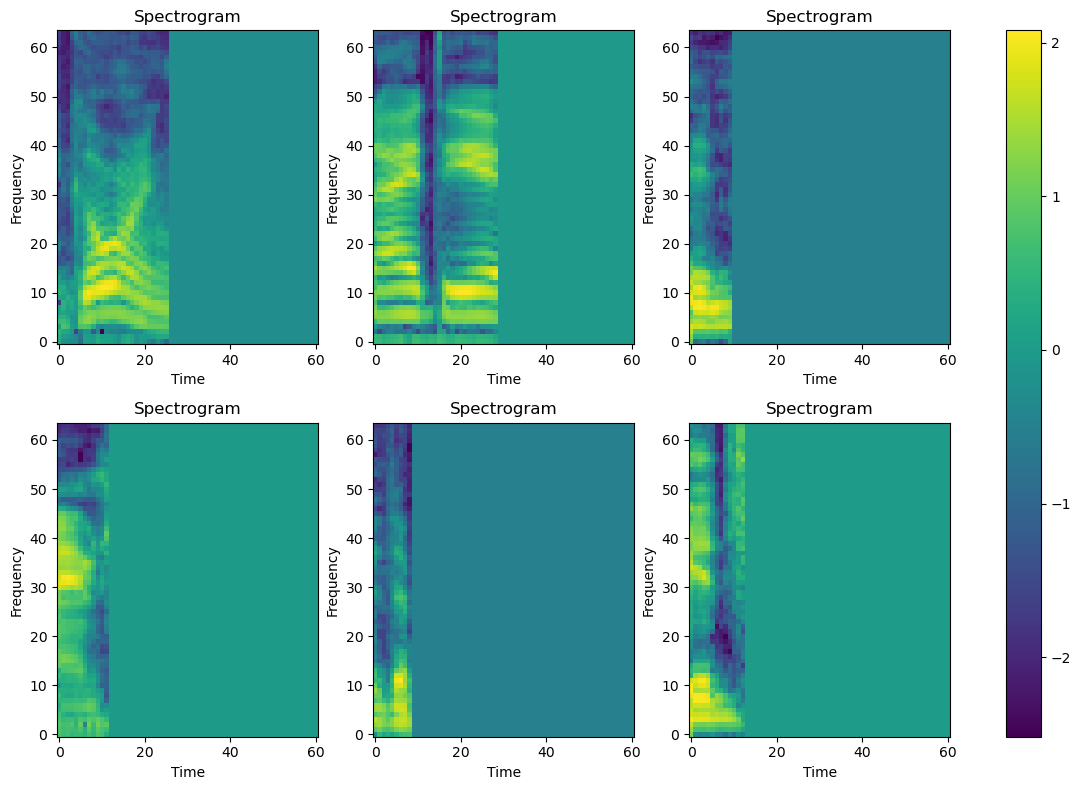

In [11]:
# Set the random seed for reproducibility
# random.seed(101)
# Generate six random indices
# random_indices = random.sample(range(len(xx_pad)), 6)
random_indices = list(range(6, 12))

# Plot the spectrograms and mark the corresponding seg
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for i, idx in enumerate(random_indices):
    spectrogram = xx_pad[idx]
    
    ax = axes[i]
    img = ax.imshow(spectrogram.T, aspect='auto', origin="lower")
    # ax.axvline(x=segment, color='red', linestyle='--')
    # ax.axvline(x=segment[1], color='red', linestyle='--')
    ax.set_title(f'Spectrogram')
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency')
plt.tight_layout()
plt.colorbar(img,ax=axes)
plt.show()

## Prepare model

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
recon_loss = nn.MSELoss(reduction='none')
masked_recon_loss = MaskedLoss(recon_loss)
model_loss = masked_recon_loss

model = TheLearner(enc_size_list=ENC_SIZE_LIST, dec_size_list=DEC_SIZE_LIST, num_layers=2)
# model = TheLearner(enc_size_list=ENC_SIZE_LIST, dec_size_list=DEC_SIZE_LIST, num_layers=1)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

model_str = str(model)
model_txt_path = os.path.join(model_save_dir, "model.txt")

with open(model_txt_path, "w") as f:
    f.write(model_str)

In [13]:
# # initialize model weights
# def init_weights(m):
#     if isinstance(m, nn.Linear):
#         torch.nn.init.orthogonal_(m.weight)
#         m.bias.data.fill_(0.01)
#     if isinstance(m, nn.LSTM): 
#         for name, p in m.named_parameters():
#             if "weight" in name: 
#                 nn.init.orthogonal_(p)
#             elif "bias" in name: 
#                 nn.init.constant_(p, 0)

# model.apply(init_weights)

In [13]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])

In [14]:
params

11296

### Load model if READ

In [16]:
if READ: 
    valid_losses.read()
    train_losses.read()

    model_name = "{}.pt".format(stop_epoch)
    model_path = os.path.join(model_save_dir, model_name)
    state = torch.load(model_path)

    model.load_state_dict(state)
    model.to(device)

In [33]:
EPOCHS = 20
BASE = 60

In [34]:
def train(): 
    for epoch in range(BASE, BASE + EPOCHS):
        text_hist.print("Epoch {}".format(epoch))

        model.train()
        train_loss = 0.
        train_num = len(train_loader)    # train_loader
        for idx, (x, x_lens) in enumerate(train_loader):
            optimizer.zero_grad()
            y = x 
            
            x_mask = generate_mask_from_lengths_mat(x_lens, device=device)
            
            x = x.to(device)
            y = y.to(device)

            recon_x, attn_weight = model(x, x_lens, x_mask)

            loss = model_loss.get_loss(recon_x, y, x_mask)

            train_loss += loss.item()

            loss.backward()
            
            # torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            # 这个函数计算的是全局梯度范数
            # torch.nn.utils.clip_grad_norm(parameters=model.parameters(), max_norm=5, norm_type=2)
            torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=5, norm_type=2)
            # parameters: an iterable of Variables that will have gradients normalized
            # max_norm: max norm of the gradients(阈值设定)
            # norm_type: type of the used p-norm. Can be'inf'for infinity norm(定义范数类型)

            optimizer.step()

            if idx % 100 == 0:
                text_hist.print(f"Training loss {loss: .3f} in Step {idx}")

        train_losses.append(train_loss / train_num)
        text_hist.print(f"※※※Training loss {train_loss / train_num: .3f}※※※")

        last_model_name = "{}.pt".format(epoch)
        torch.save(model.state_dict(), os.path.join(model_save_dir, last_model_name))
        text_hist.print("Training timepoint saved")

        model.eval()
        valid_loss = 0.
        valid_num = len(valid_loader)
        for idx, (x, x_lens) in enumerate(valid_loader):
            y = x    # extract MFCC-only data
            x_mask = generate_mask_from_lengths_mat(x_lens, device=device)
            
            x = x.to(device)
            y = y.to(device)

            recon_x, attn_weight = model(x, x_lens, x_mask)

            loss = model_loss.get_loss(recon_x, y, x_mask)

            valid_loss += loss.item()

            if idx % 50 == 0:
                text_hist.print(f"Valid loss {loss: .3f} in Step {idx}")

        valid_losses.append(valid_loss / valid_num)

        text_hist.print(f"※※※Valid loss {valid_loss / valid_num: .3f}※※※")

In [35]:
if __name__ == "__main__": 
    train()

Epoch 60
Training loss  0.254 in Step 0
Training loss  0.242 in Step 100
Training loss  0.242 in Step 200
Training loss  0.242 in Step 300
※※※Training loss  0.241※※※
Training timepoint saved
Valid loss  0.245 in Step 0
※※※Valid loss  0.248※※※
Epoch 61
Training loss  0.237 in Step 0
Training loss  0.239 in Step 100
Training loss  0.234 in Step 200
Training loss  0.239 in Step 300
※※※Training loss  0.240※※※
Training timepoint saved
Valid loss  0.245 in Step 0
※※※Valid loss  0.247※※※
Epoch 62
Training loss  0.241 in Step 0
Training loss  0.246 in Step 100
Training loss  0.232 in Step 200
Training loss  0.243 in Step 300
※※※Training loss  0.241※※※
Training timepoint saved
Valid loss  0.244 in Step 0
※※※Valid loss  0.246※※※
Epoch 63
Training loss  0.236 in Step 0
Training loss  0.247 in Step 100
Training loss  0.247 in Step 200
Training loss  0.242 in Step 300
※※※Training loss  0.239※※※
Training timepoint saved
Valid loss  0.244 in Step 0
※※※Valid loss  0.246※※※
Epoch 64
Training loss  0.24

In [36]:
### Save
train_losses.save()

valid_losses.save()

text_hist.save()

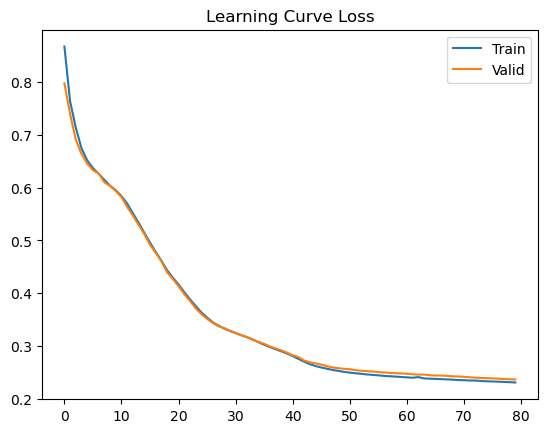

In [37]:
plt.plot(train_losses.get(), label='Train')
plt.plot(valid_losses.get(), label='Valid')
plt.title("Learning Curve Loss")
plt.legend()
plt.savefig(os.path.join(model_save_dir, "train.png"))

In [28]:
valid_losses.get()

[0.6973373221188057,
 0.5841517593802475,
 0.46406597117098364,
 0.44220086641427947,
 0.433954004107452,
 0.40526596729348346,
 0.4018787022044019,
 0.38418969802740144,
 0.3629494374845086,
 0.3243178616209728,
 0.2918721691864293,
 0.2824630453819182,
 0.27500432366278116,
 0.26278095855945494,
 0.2574981138473604,
 0.25056687578922365,
 0.25194803752550265,
 0.24937494498927418,
 0.2532334076922114,
 0.2538182386537878,
 0.26212876744386626,
 0.26849532272757554,
 0.2811444946905462,
 0.2902815022119662,
 0.30480065723744837,
 0.3194227662028336,
 0.33510804030953384,
 0.3481292710071657,
 0.35091513467998037,
 0.3703691254301769]

## Conclusion
This model should converge to loss around 0.49x. 